In [1]:
# imports
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader,TensorDataset, Dataset

import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
import torchvision
from sklearn.model_selection import train_test_split


In [14]:
########Data loading
def img_loader(data_dir):
    "This function saves all images in 'data_dir' in a tensor"
    ### reducing the size to 64*256
    rs = transforms.Resize([64,256])
    filenames = [name for name in os.listdir(data_dir)]
    filenames = np.sort(filenames)
    batch_size = len(filenames)
    out = torch.zeros(batch_size, 3, 256, 1024, dtype=torch.uint8)
    for i, filename in enumerate(filenames):
        out[i] = torchvision.io.read_image(os.path.join(data_dir, filename))
    return rs(out)

def find_folders_in_directory(directory):
    """
    Finds all folders in the given directory.
    """
    folders = []
    # Walk through the directory
    for entry in os.scandir(directory):
        # Check if the entry is a directory
        if entry.is_dir():
            folders.append(entry.path)
    return folders


def load_all_img(data_dir,folder_name):
    "load all images in all folders of data_dir"
    out = []
    fnames = find_folders_in_directory(data_dir)
    for fn in fnames:
        dir = os.path.join(fn,folder_name)
        dataf = img_loader(dir)
        if len(out) == 0:
            out = dataf
        else:
            out = torch.vstack((out, dataf))

    return out

def load_all_img2(data_dir,folder_name):
    out = []
    fnames = find_folders_in_directory(data_dir)
    for fn in fnames:
        
        # dir = os.path.join(fn,folder_name)
        dataf = load_all_img(fn,folder_name)
        if len(out) == 0:
            out = dataf
        else:
            out = torch.vstack((out, dataf))

    return out

In [15]:
#### loading input and output images from folders
# input_img=load_all_img('/home/lambda2/carla_garage/data/ll_dataset_2023_05_10/Routes_Town04_ll_Repetition0', 'rgb')
# depth_img=load_all_img('/home/lambda2/carla_garage/data/ll_dataset_2023_05_10/Routes_Town04_ll_Repetition0', 'depth')


input_img=load_all_img2('/home/lambda2/carla_garage/data/ll_dataset_2023_05_10', 'rgb')
depth_img=load_all_img2('/home/lambda2/carla_garage/data/ll_dataset_2023_05_10', 'depth')

### normalizing the data
input_img = input_img/input_img.max()
depth_img =depth_img /depth_img.max()

In [18]:
print(input_img.shape)
print(depth_img.shape)

torch.Size([30546, 3, 64, 256])
torch.Size([30546, 3, 64, 256])


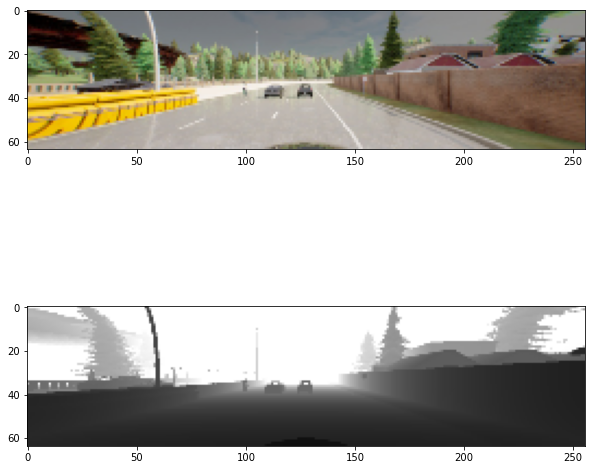

In [24]:
#### An Example of a data point
test_adrs=30000


fig, ax = plt.subplots(2, sharex='row', sharey='row',figsize=(10,10))
img = input_img[test_adrs]
label = depth_img[test_adrs]
im=ax[0].imshow(img.permute(1,2,0))
# # fig.colorbar(im,cax=ax[0])
im2=ax[1].imshow(label.permute(1,2,0))
# fig.colorbar(im1,cax=ax[1])

In [30]:
test_train_ratio = 0.9
def split_train_test(tensor_data, label_tensor, train_ratio=0.9):
    """
    Shuffles the data and splits it into training and test datasets.

    Parameters:
    - tensor_data (Tensor): The tensor containing all data.
    - train_ratio (float): The proportion of the dataset to include in the train split (default is 0.8).

    Returns:
    - train_data (Tensor): Tensor containing the training data.
    - test_data (Tensor): Tensor containing the test data.
    """
    # Number of entries in the dataset
    num_entries = tensor_data.size(0)
   
    # Shuffle indices
    indices = torch.randperm(num_entries)

    # Calculate the number of entries for the train set
    train_size = int(train_ratio * num_entries)
   
    # Split indices for train and test
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
   
    # Create train and test sets
    train_data = tensor_data[train_indices]
    test_data = tensor_data[test_indices]
    train_label = label_tensor[train_indices]
    test_label = label_tensor[test_indices]

    return train_data, test_data, train_label, test_label


train_data, test_data, train_label, test_label= split_train_test(input_img, depth_img)


print(train_data.shape)
print(test_data.shape)

print(train_label.shape)
print(test_label.shape)
# input_img_train = input_img[0:int(np.floor(test_train_ratio*len(input_img)))]
# input_img_test = input_img[int(np.floor(test_train_ratio*len(input_img))):]


torch.Size([27491, 3, 64, 256])
torch.Size([3055, 3, 64, 256])
torch.Size([27491, 3, 64, 256])
torch.Size([3055, 3, 64, 256])


In [34]:
# #### An Example of a data point
# test_adrs=300


# fig, ax = plt.subplots(2, sharex='row', sharey='row',figsize=(10,10))
# img = test_data[test_adrs]
# label = test_label[test_adrs]
# im=ax[0].imshow(img.permute(1,2,0))
# # # fig.colorbar(im,cax=ax[0])
# im2=ax[1].imshow(label.permute(1,2,0))
# # fig.colorbar(im1,cax=ax[1])

In [ ]:

###Creating a dataloader
train_dataloader = DataLoader(dataset = TensorDataset(train_data, train_label), batch_size=64, shuffle=True, num_workers=16)
test_dataloader = DataLoader(dataset = TensorDataset(test_data, test_label), batch_size=64, shuffle=True, num_workers=16)


torch.cuda.empty_cache()

In [37]:
torch.cuda.empty_cache()

In [85]:
class UNet(nn.Module):
    def __init__(self, c):
        super(UNet, self).__init__()
        # Convolutional Block in Encoder Section at Level i: ei   --   Decoder Section: di
        self.e01 = nn.Conv2d(in_channels= 3, out_channels=c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn01 = nn.BatchNorm2d(num_features=c)
        self.e02 = nn.Conv2d(in_channels=c, out_channels=c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn02 = nn.BatchNorm2d(num_features=c)
        
        self.e11 = nn.Conv2d(in_channels=c, out_channels=2*c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn11 = nn.BatchNorm2d(num_features=2*c)
        self.e12 = nn.Conv2d(in_channels=2*c, out_channels=2*c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn12 = nn.BatchNorm2d(num_features=2*c)
        
        self.e21 = nn.Conv2d(in_channels=2*c, out_channels=4*c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn21 = nn.BatchNorm2d(num_features=4*c)
        self.e22 = nn.Conv2d(in_channels=4*c, out_channels=4*c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn22 = nn.BatchNorm2d(num_features=4*c)
        
        self.e31 = nn.Conv2d(in_channels=4*c, out_channels=8*c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn31 = nn.BatchNorm2d(num_features=8*c)
        self.e32 = nn.Conv2d(in_channels=8*c, out_channels=8*c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn32 = nn.BatchNorm2d(num_features=8*c)
        
        
        self.d21 = nn.Conv2d(in_channels=8*c, out_channels=4*c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn23 = nn.BatchNorm2d(num_features=4*c)
        self.d22 = nn.Conv2d(in_channels=4*c, out_channels=4*c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn24 = nn.BatchNorm2d(num_features=4*c)
        
        self.d11 = nn.Conv2d(in_channels=4*c, out_channels=2*c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn13 = nn.BatchNorm2d(num_features=2*c)
        self.d12 = nn.Conv2d(in_channels=2*c, out_channels=2*c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn14 = nn.BatchNorm2d(num_features=2*c)
        
        self.d01 = nn.Conv2d(in_channels=2*c, out_channels=c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn03 = nn.BatchNorm2d(num_features=c)
        self.d02 = nn.Conv2d(in_channels=c, out_channels=c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn04 = nn.BatchNorm2d(num_features=c)
        
        # Increaseing the resolution of image from a lower level to match the upper level
        self.upconv3 = nn.ConvTranspose2d(in_channels=8*c, out_channels=4*c, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(in_channels=4*c, out_channels=2*c, kernel_size=2, stride=2)
        self.upconv1 = nn.ConvTranspose2d(in_channels=2*c, out_channels=c, kernel_size=2, stride=2)
        ### Fully connected layer
        self.fc1 = nn.Linear(40960, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 3)
        self.softmax = nn.Softmax(dim=3)

        # Output
        self.out = nn.Conv2d(in_channels=c, out_channels=3, kernel_size=3, stride=1, padding=1)
        
        self.maxpool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.sig=nn.Sigmoid()
        self.sm = nn.Softmax()

    def forward(self, x):
        # encoder
        ### x0: output encoder0 
        x0 = self.relu(self.bn02(self.e02(self.relu(self.bn01(self.e01(x))))))
        x = self.maxpool(x0)
        ### x1: output encoder 1
        x1 = self.relu(self.bn12(self.e12(self.relu(self.bn11(self.e11(x))))))
        x = self.maxpool(x1)
        
        ### x2: output encoder 2
        x2 = self.relu(self.bn22(self.e22(self.relu(self.bn21(self.e21(x))))))
        x = self.maxpool(x2)
        
        x = self.relu(self.bn32(self.e32(self.relu(self.bn31(self.e31(x))))))
        
      

        # decoder
        x = torch.cat((self.upconv3(x), x2), dim=1)
        x = self.relu(self.bn24(self.d22(self.relu(self.bn23(self.d21(x))))))
        
        x = torch.cat((self.upconv2(x), x1), dim=1)
        x = self.relu(self.bn14(self.d12(self.relu(self.bn13(self.d11(x))))))

        x = torch.cat((self.upconv1(x), x0), dim=1)
        x = self.relu(self.bn04(self.d02(self.relu(self.bn03(self.d01(x))))))

        out = self.out(x)
        # out=self.relu(out)
        out = self.sig(out)
#         return out

        return  out

In [86]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.5):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
       
    def forward(self, pred_logits, target):
        pred = pred_logits.sigmoid()
        ce = F.binary_cross_entropy_with_logits(pred_logits, target, reduction = 'none')
        alpha = target*self.alpha + (1. - target )*(1. - self.alpha)
        pt = torch.where(target == 1, pred, 1- pred)
        return alpha* (1. - pt)**self.gamma * ce

In [87]:
#Initializing the network
device = 'cuda:0'
model = UNet(32).float().to(device)
model.train()

UNet(
  (e01): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn01): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e02): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn02): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e11): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn21): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn22): BatchNorm

In [88]:
#### Hyperparameteres and loss function
n_epochs=15
learning_rate=0.001
# criterion = FocalLoss()

criterion = nn.L1Loss()
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)


In [100]:
#Train the network
loss_ls=[]
for epoch in range(n_epochs):
    loss_sum=0
    for batch_idx, (data, target) in enumerate(train_dataloader):


        data=data.float().to(device)
        target=target.float().to(device)



        #forward
        output=model(data).float().to(device)
        
        loss = criterion(output, target).mean()
        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum=loss_sum+loss
    # if epoch ==5:
    #     learning_rate = learning_rate
    #     optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    loss_ls.append(loss_sum)
    print('epoch:',epoch, '\n', loss_sum)
    PATH = 'm'+str(epoch)
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_sum}, PATH)

    
    


epoch: 0 
 tensor(5.7762, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 1 
 tensor(5.7762, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 2 
 tensor(5.7765, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 3 
 tensor(5.7755, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 4 
 tensor(5.7756, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 5 
 tensor(5.7761, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 6 
 tensor(5.7763, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 7 
 tensor(5.7754, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 8 
 tensor(5.7757, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 9 
 tensor(5.7755, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 10 
 tensor(5.7762, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 11 
 tensor(5.7759, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 12 
 tensor(5.7757, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 13 
 tensor(5.7756, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 14 
 tensor(5.7767, device='cuda:0', grad_fn=<AddBa

/tmp/ipykernel_785180/2854973677.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ls = torch.tensor(loss_ls)


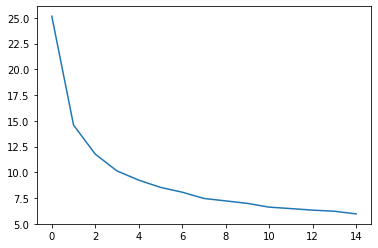

In [99]:
###### Plotting the Train loss
loss_ls = torch.tensor(loss_ls)
plt.plot(loss_ls)
plt.savefig('Trainloss.png', dpi =300)

In [76]:
# #########Loading a model
# PATH = 'Final_BCE'
# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
# model.to(device)
# model.eval()

UNet(
  (e01): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn01): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e02): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn02): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e11): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn21): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn22): BatchNorm

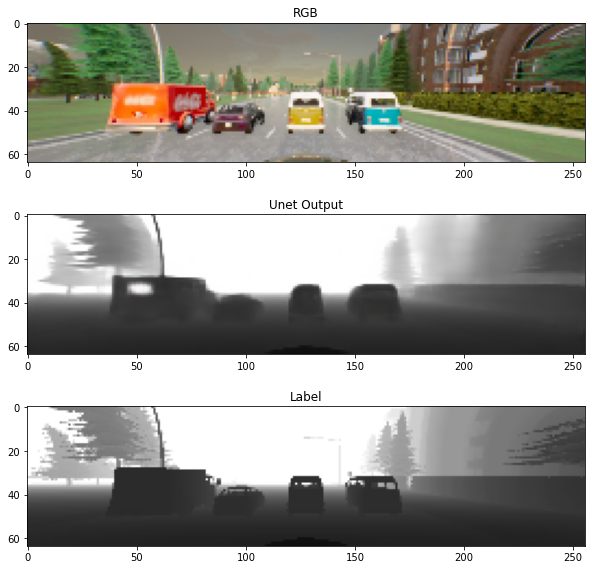

In [91]:

#####Train Example
test_adrs=26
output=model((train_data[test_adrs:test_adrs+1,:,:,:]).to(device).float())
output = output.cpu().detach()
# output = torch.sigmoid(output)
# out_decoder = torch.abs(out_decoder)
# out_decoder = out_decoder/out_decoder.max()



fig, ax = plt.subplots(3, sharex='row', sharey='row',figsize=(10,10))
img = train_data[test_adrs]
label = train_label[test_adrs]
im=ax[0].imshow(img.permute(1,2,0))

# # fig.colorbar(im,cax=ax[0])
im1=ax[1].imshow(output[0].permute(1,2,0))
im2=ax[2].imshow(label.permute(1,2,0))
# fig.colorbar(im1,cax=ax[1])
ax[0].title.set_text('RGB')
ax[1].title.set_text('Unet Output')
ax[2].title.set_text('Label')

# fig.savefig('Train_example.png', dpi = 400)

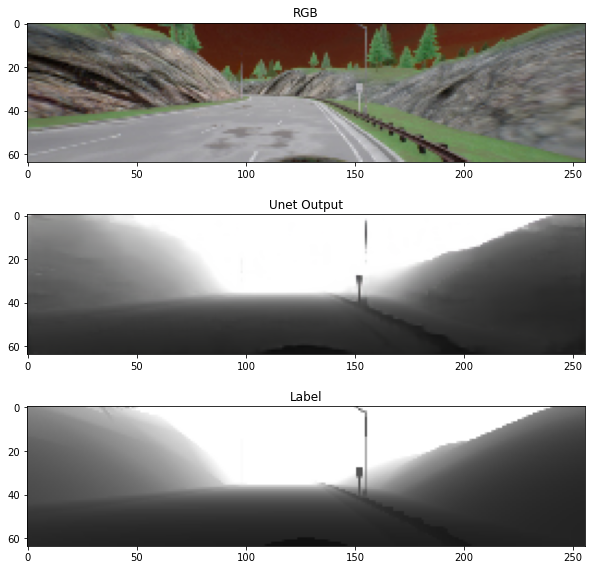

In [94]:
#########Test Example

test_adrs=9
output=model((test_data[test_adrs:test_adrs+1,:,:,:]).to(device).float())
output = output.cpu().detach()
# output = torch.sigmoid(output)
# out_decoder = torch.abs(out_decoder)
# out_decoder = out_decoder/out_decoder.max()



fig, ax = plt.subplots(3, sharex='row', sharey='row',figsize=(10,10))
img = test_data[test_adrs]
label = test_label[test_adrs]

im=ax[0].imshow(img.permute(1,2,0))

# # fig.colorbar(im,cax=ax[0])

im1=ax[1].imshow(output[0].permute(1,2,0))

im2=ax[2].imshow(label.permute(1,2,0))
# fig.colorbar(im1,cax=ax[1])
ax[0].title.set_text('RGB')
ax[1].title.set_text('Unet Output')
ax[2].title.set_text('Label')
fig.savefig('Test_example.png', dpi = 400)


In [ ]:
device

In [ ]:
# model = UNet(32).float()
# model.eval()
# PATH = 'm'+str(epoch)
# checkpoint = torch.load(PATH)
# # model.load_state_dict(checkpoint['model_state_dict'])

In [95]:
loss_test_ls=[]
with torch.no_grad():
        for epoch in range(n_epochs):
                torch.cuda.empty_cache()
                model = UNet(32).float()
                PATH = 'm'+str(epoch)
                checkpoint = torch.load(PATH, map_location=torch.device('cpu'))
                model.load_state_dict(checkpoint['model_state_dict'])
                model.to(device)
                model.eval()
                
                loss_sum=0
                        
                

                for batch_idx, (data, target) in enumerate(test_dataloader):
                        
                                        
                        data=data.float().to(device)
                        target=target.float().to(device)



                        #forward
                        output=model(data).float().to(device)
                        
                        loss = criterion(output, target).mean()
                        #backward
                        
                        loss_sum=loss_sum+loss
                             
                loss_test_ls.append(loss_sum)
                print(loss_sum)
                

        
        


tensor(2.2481, device='cuda:0')
tensor(1.4834, device='cuda:0')
tensor(1.1738, device='cuda:0')
tensor(1.3044, device='cuda:0')
tensor(1.0186, device='cuda:0')
tensor(0.9741, device='cuda:0')
tensor(0.9744, device='cuda:0')
tensor(0.8544, device='cuda:0')
tensor(0.7903, device='cuda:0')
tensor(0.7931, device='cuda:0')
tensor(0.7580, device='cuda:0')
tensor(0.7522, device='cuda:0')
tensor(0.7170, device='cuda:0')
tensor(0.7607, device='cuda:0')
tensor(0.6827, device='cuda:0')


/tmp/ipykernel_785180/3079821250.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_test_ls = torch.tensor(loss_test_ls)


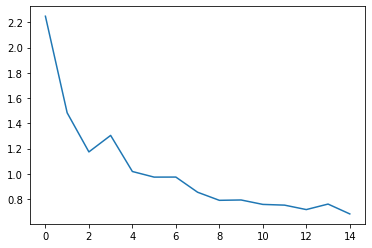

In [98]:
loss_test_ls = torch.tensor(loss_test_ls)
plt.plot(loss_test_ls)
plt.savefig('Testloss.png', dpi =300)

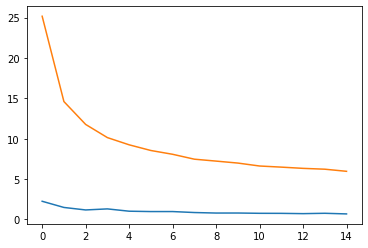